In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_context('talk')

import numpy as np
import scipy
import pandas as pd
import nptdms

import gc # garbage collector

In [2]:
file_path = 'D:/Work/20160616-white_noise-library.tdms'
tdms_file = nptdms.TdmsFile(file_path)

In [3]:
# initialize dataframe to hold information about each motor start
trials = pd.DataFrame(index=np.arange(len(tdms_file.groups())), 
                         columns = ['seed','freq','gain','rep'])
trials['name'] = tdms_file.groups()

In [4]:
# function that gets property *prop* of the wanted trial *t* from TDMS file
get_property = lambda t, prop: tdms_file.object(t).property(prop)

In [5]:
for t in trials.index:
    trials.at[t, 'freq'] = get_property(trials.at[t,'name'],'modulation freq')
    trials.at[t, 'gain'] = get_property(trials.at[t,'name'],'gain')
    trials.at[t, 'seed'] = get_property(trials.at[t,'name'],'seed ID')

In [6]:
# get all channels (streams) data into dataframes too
df_temp = tdms_file.as_dataframe()

# amplifier monitor traces
amplifier_traces = df_temp.loc[:,["/'%s'/'ampli monitor'" % t for t in trials.name]]\
                    .transpose().reset_index(drop=True)
    
# original signals traces
signal_traces = df_temp.loc[:,["/'%s'/'shaker signal'" % t for t in trials.name]]\
                    .transpose().reset_index(drop=True)
    
# laser rangefinder traces
shaker_traces = df_temp.loc[:,["/'%s'/'shaker position'" % t for t in trials.name]]\
                    .transpose().reset_index(drop=True)
    
del df_temp
del tdms_file
gc.collect() # force garbage collector to free memory

28831

In [7]:
# mark the repetition number for all stimuli
import itertools

get_stim_ix = lambda seed, freq, gain: trials.loc[(trials['seed']==seed) & 
                                                  (trials['freq']==freq) & 
                                                  (trials['gain']==gain)]

for (seed, freq, gain) in itertools.product(trials.seed.unique(),
                                            trials.freq.unique(),
                                            trials.gain.unique()):
    
    ix = get_stim_ix(seed,freq,gain).index
    trials.loc[ix,'rep'] = np.arange(1,len(ix)+1)

Laser finder introduces noise above the spectrum of the vibration shaker (>500 Hz). I filter it with polynomial approximation (Savitzky–Golay filter) to keep the waveform and timing intact.

In [8]:
def fft_spectrum(signal,fs):
    import scipy
    """
    Computes a single-sided amplitude spectrum of 
    the *signal* given its sampling frequency *fs*.
    
    """
    
    # center signal to discard DC component
    signal = signal - np.mean(signal)
    
    n = len(signal) # length of the signal
    k = np.arange(n)
    T = n/fs
    freq = k/T # two sides frequency range
    freq = freq[np.arange(n//2)] # one side frequency range

    Y = scipy.fft(signal)/n # fft computing and normalization
    Y = Y[np.arange(n//2)]
    
    return np.abs(Y), freq,

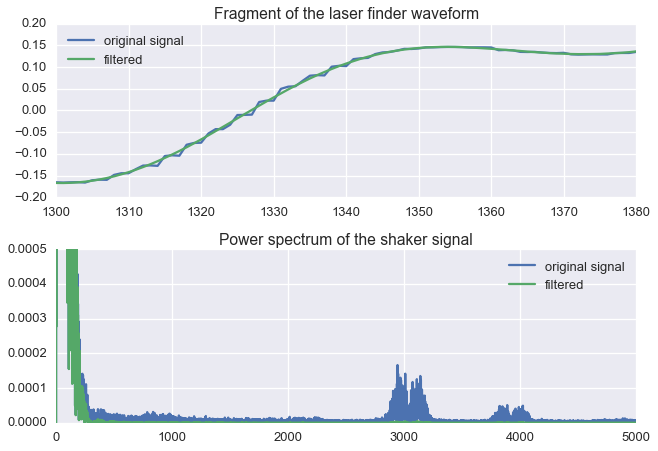

In [10]:
from scipy.signal import savgol_filter

# demonstration of the waveform and spectrum before/after filtering
trace = shaker_traces.loc[5]
trace_filt = savgol_filter(trace,101,7)
Y_orig, freq = fft_spectrum(trace,10000)
Y_filt, freq = fft_spectrum(trace_filt,10000)

fig, ax = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.3)

ax[0].plot(trace,label='original signal')
ax[0].plot(trace_filt,label='filtered')
ax[0].legend(loc='best')
ax[0].set_xlim([1300,1380])
ax[0].set_ylim([-0.2,0.2])
ax[0].set_title('Fragment of the laser finder waveform')

ax[1].plot(freq,Y_orig,label='original signal')
ax[1].plot(freq,Y_filt,label='filtered')
ax[1].legend(loc='best')
ax[1].set_ylim(0,0.0005)
ax[1].set_title('Power spectrum of the shaker signal')

plt.show()

Examine loss of power in the shaker range and in the noise range

In [11]:
# frequency range of the shaker
rs = slice(0,200)

# frequency range of the noise
rn = slice(200,5000)

# normalized loss of power in the shaker and noise range
loss_shaker = sum(abs(Y_orig[rs] - Y_filt[rs]))/(rs.stop-rs.start)
loss_noise = sum(abs(Y_orig[rn] - Y_filt[rn]))/(rn.stop-rn.start)

print("""Loss of power per frequency 
in shaker range: %s 
in noise range: %s;
Improvement of the signal-to-noise ratio: %s"""
% (loss_shaker,loss_noise,loss_noise/loss_shaker))

Loss of power per frequency 
in shaker range: 3.01145309814e-07 
in noise range: 7.15052953572e-06;
Improvement of the signal-to-noise ratio: 23.7444492831


In [12]:
# apply Savitzky-Golay filter to all shaker traces
shaker_traces = shaker_traces.apply(lambda x: savgol_filter(x,101,7),axis=1)

# Examine the delay the shaker introduces

Take first 100 stimuli together as original stimuli signals and shaker traces, normalize them and look for the peak of the cross-correlation function to find the delay.

In [13]:
# normalization function
norm = lambda x: (x-np.mean(x))/np.std(x)

signal = norm(signal_traces.loc[:9,:].as_matrix().reshape(10*20000,))

# because of the inertia, shaker has integrative properties so we suspect that the differential
# of the shaker trace is more close to the original signal; also we are actually interested
# in velocity values of the vibration due to how tactile system functions;
# thus we examine the delay between the signal and the differential on the shaker trace
shaker = norm(np.diff(shaker_traces.loc[:9,:].as_matrix().reshape(10*20000,)))

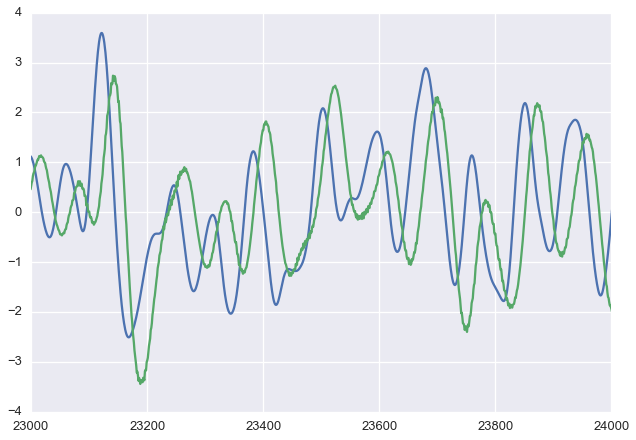

In [14]:
plt.figure()
plt.plot(signal)
plt.plot(shaker)
plt.xlim(23000,24000)
plt.ylim(-4,4)
plt.show()

In [15]:
# similarity in the signals is evident, let's find the delay
cross_corr = scipy.signal.signaltools.correlate(signal,shaker)

Second signal is delayed by 22 samples


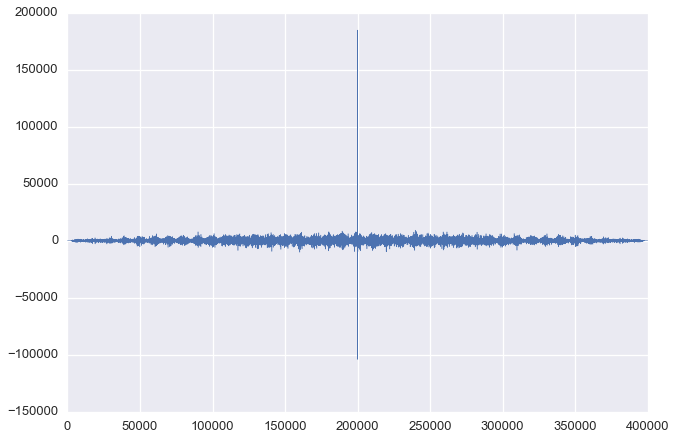

In [16]:
delay_samples = len(signal) - np.argmax(cross_corr)
print('Second signal is delayed by %s samples' % delay_samples)

# verify that cross-correlation has one single peak
plt.figure()
plt.plot(cross_corr,linewidth=0.5)
plt.show()

In [17]:
def align_signals(early_signal,late_signal,samples_delay):
    """
    Aligns two signals by padding their ends with zeros.
    """
    return np.append(np.zeros(samples_delay),early_signal), \
           np.append(late_signal, np.zeros(samples_delay))

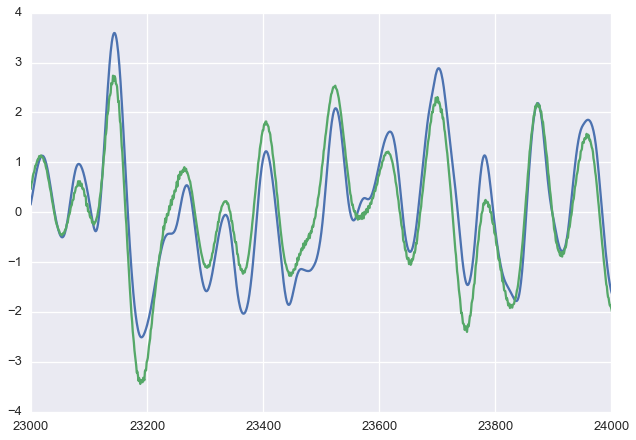

In [18]:
signal, shaker = align_signals(signal,shaker,delay_samples)

# check singal alignment
plt.figure()
plt.plot(signal)
plt.plot(shaker)
plt.xlim(23000,24000)
plt.ylim(-4,4)
plt.show()

Examine the difference between the original signal and the shaker to get an idea about transformation of the signal by the shaker

Conclusions:
- Savitzky-Golay filter is well suited for filtering liser finder signal (exact parameters: window size = 101 samples, 7th order polynomial);
- derivative of the shaker signal is close to the original signal, signifying integrative properties of the shaker (due to inertia of the physical system); in other words, original stimulus signal becomes the velocity of the vibration, not the position;
- the delay between the stimulus signal and the shaker output is 22 samples, or $2.2\pm0.05$ ms;
- the derivative of the shaker does not fully repeat the the shape of the original signal, but the transformation is non-trivial: sometimes the shaker underperforms the signal and sometimes overperforms it;